## Learning Objectives

Today we learn a hack to increase the size of our training set while still being able to do validation: cross validation.

## Validation?

Let's remember when we first introduced validation. At one point we only had a single clump of data, the training data. But then we said that it was a wonderful idea to split that data into three different groups. One group was again the training group. This group gives us the initial bound (which we showed allowed us to learn in the first place). The next group is the test group. This group will give us the final bootstrap bound on confidence of our algorithm. These will be the numbers that we present to our boss. The final group was the validation group. This group was special. As we developed new algorithms to learn from the data we would repeated look to this group to tell us how well we were doing. This group was special. It would tell us internally how we were doing, but we would not present the numbers that we got on the validation group to our boss. 

For example we would use the validation group to decide what regularization to use. Notice how validation tracks the test error that we get below (not exactly but it is a good estimate):

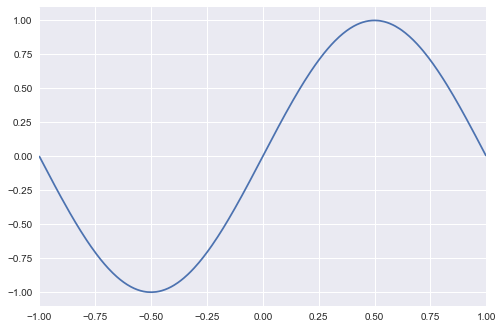

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns

X = np.random.uniform(-1, 1, size=1000)
y = np.sin(np.pi * X)

sns.tsplot(y, X)

In [90]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

train_error = []
val_error = []
test_error = []

for i, regularization in enumerate(range(1, 60, 2)):
    train_error.append([])
    val_error.append([])
    test_error.append([])
    for trial in range(100):
        X_train = np.random.uniform(-1, 1, size=20)
        y_train = np.sin(np.pi * X_train)
        X_val = np.random.uniform(-1, 1, size=20)
        y_val = np.sin(np.pi * X_val)
        
        poly = PolynomialFeatures(10)

        # this is where the regularization is taking place!
        reg = Ridge(alpha=1./regularization, fit_intercept=False)

        x_tran = poly.fit_transform(X_train[:, None])
        reg.fit(x_tran, y_train)

        data = [(X_train, y_train, train_error), (X_val, y_val, val_error), (X, y, test_error)]

        for xs, ys, errors in data:
            x_tran = poly.fit_transform(xs[:, None])
            # now we score both hypotheses on the traning data
            preds = reg.predict(x_tran)
            errors[i].append(mean_squared_error(preds, ys))


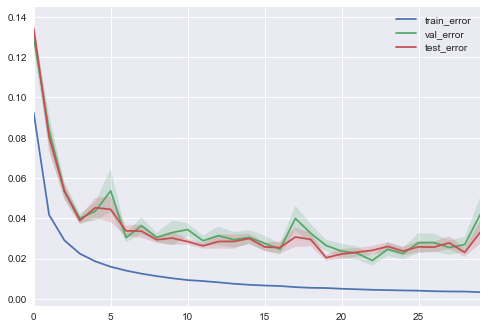

In [91]:
sns.tsplot(np.array([train_error, val_error, test_error]).T, 
            condition=['train_error', 'val_error', 'test_error'])

Notice that the test error and the validation error curves tightly track one another. Notice that they are concave (hold water), there is a minimum and that minimum is close on both curves. Notice the training error is just always going down. So yes validation works!

## The problem with validation

As we said in the previous lecture, we would choose around 1/5th of the data points to be validation (with a max of 10k). You see the problem?

The fewer training data points we have, in general the worse our performance. (Remember the approx-gen trade off or the bias-variance trade off). So we want as many data points as possible, but we definitely need Validation. So what do we do...

One choice is to reduce the size of the validation set. You probably have an intuition what would happen if we reduce the size of the validation. Again our bound one what the test error should be will go away. Let's try below to shrink the validation set:

In [92]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

train_error = []
val_error = []
test_error = []

for i, regularization in enumerate(range(1, 60, 2)):
    train_error.append([])
    val_error.append([])
    test_error.append([])
    for trial in range(100):
        X_train = np.random.uniform(-1, 1, size=20)
        y_train = np.sin(np.pi * X_train)
        X_val = np.random.uniform(-1, 1, size=4)
        y_val = np.sin(np.pi * X_val)
        
        poly = PolynomialFeatures(10)

        # this is where the regularization is taking place!
        reg = Ridge(alpha=1./regularization, fit_intercept=False)

        x_tran = poly.fit_transform(X_train[:, None])
        reg.fit(x_tran, y_train)

        data = [(X_train, y_train, train_error), (X_val, y_val, val_error), (X, y, test_error)]

        for xs, ys, errors in data:
            x_tran = poly.fit_transform(xs[:, None])
            # now we score both hypotheses on the traning data
            preds = reg.predict(x_tran)
            errors[i].append(mean_squared_error(preds, ys))


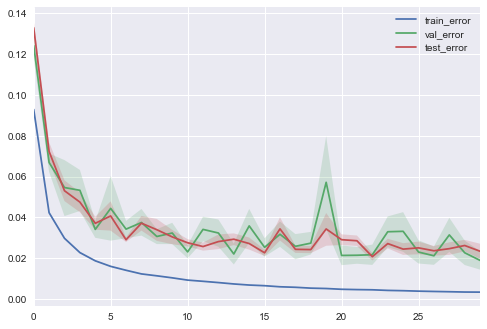

In [93]:
sns.tsplot(np.array([train_error, val_error, test_error]).T, 
            condition=['train_error', 'val_error', 'test_error'])

So yes the validation error does track the test error, but it becomes even more sparatic. It jumps all over the place. If we reduce it even more:

In [94]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

train_error = []
val_error = []
test_error = []

for i, regularization in enumerate(range(1, 60, 2)):
    train_error.append([])
    val_error.append([])
    test_error.append([])
    for trial in range(100):
        X_train = np.random.uniform(-1, 1, size=20)
        y_train = np.sin(np.pi * X_train)
        X_val = np.random.uniform(-1, 1, size=1)
        y_val = np.sin(np.pi * X_val)
        
        poly = PolynomialFeatures(10)

        # this is where the regularization is taking place!
        reg = Ridge(alpha=1./regularization, fit_intercept=False)

        x_tran = poly.fit_transform(X_train[:, None])
        reg.fit(x_tran, y_train)

        data = [(X_train, y_train, train_error), (X_val, y_val, val_error), (X, y, test_error)]

        for xs, ys, errors in data:
            x_tran = poly.fit_transform(xs[:, None])
            # now we score both hypotheses on the traning data
            preds = reg.predict(x_tran)
            errors[i].append(mean_squared_error(preds, ys))


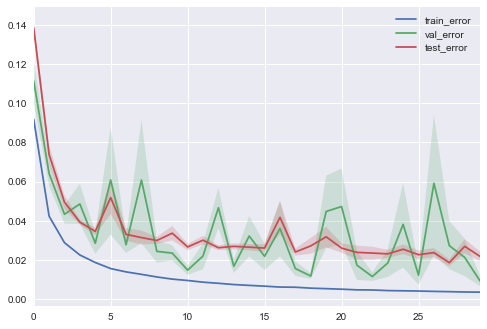

In [95]:
sns.tsplot(np.array([train_error, val_error, test_error]).T, 
            condition=['train_error', 'val_error', 'test_error'])

The validation error that we get is mostly useless. So what do we do?

We again have a trade off: better validation accuracy for better training results. Which one do we choose. Well in this case we don't need to choose! We actually have a hack.

We can get the best of both worlds! This is called cross validation.

## Cross validation

In cross validation we use the training set as the validation set. How you ask?

What we do is we split the training data into 5 groups randomly. We then use the first four of those groups to train and the last of those groups to validate. We then repeat this process four times for a total of 5 trains and 5 validates. We then average the validation scores. 

Cross validation tracks the test error extremely well while maintaining a relitively small validation set (it is almost as if you are using the entire training data set for validation!)

Let's check out how well having a cross validation set of a single example works below:

In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

train_error = []
val_error = []
test_error = []
cv_error = []

for i, regularization in enumerate(range(1, 60, 2)):
    train_error.append([])
    val_error.append([])
    test_error.append([])
    cv_error.append([])
    for trial in range(100):
        X_train = np.random.uniform(-1, 1, size=20)
        y_train = np.sin(np.pi * X_train)
        X_val = np.random.uniform(-1, 1, size=1)
        y_val = np.sin(np.pi * X_val)
        
        poly = PolynomialFeatures(10)

        # this is where the regularization is taking place!
        reg = Ridge(alpha=1./regularization, fit_intercept=False)

        x_tran = poly.fit_transform(X_train[:, None])
        reg.fit(x_tran, y_train)

        data = [(X_train, y_train, train_error), (X_val, y_val, val_error), (X, y, test_error)]

        for xs, ys, errors in data:
            x_tran = poly.fit_transform(xs[:, None])
            # now we score both hypotheses on the traning data
            preds = reg.predict(x_tran)
            errors[i].append(mean_squared_error(preds, ys))
            
        X_full = np.concatenate([X_train, X_val])
        y_full = np.concatenate([y_train, y_val])
        reg = Ridge(alpha=1./regularization, fit_intercept=False)

        x_tran = poly.fit_transform(X_full[:, None])
        
        scores = cross_val_score(reg, x_tran, y_full, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
        cv_error[i].append(-scores.mean())
            
        


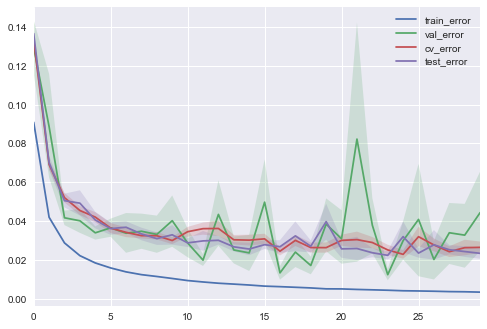

In [111]:
sns.tsplot(np.array([train_error, val_error, cv_error, test_error]).T, 
            condition=['train_error', 'val_error', 'cv_error', 'test_error'])

Now even though we are only using 'one' example in our validation set, we can still track the test error quite well.

Based on the amount of time that we spent waiting for that to finish, you may have guessed the trade off that we are actually making. In this case we are making a trade off between computation time and validation accuracy. In most small data settings this is a trade off that you would happily make, but in large data regimes, people are willing to have a set validation data set for better or worse. 

## The final hack

Now there is one final hack that we can do to boost performance. Right before we want to hand our model over to the test set to determine what our final accuracy will be, we combine all the training and validation data into one pool and use it to train the final model. 

This should give you a small boost to performance without sacrificing anything (I think of it like burning the boats).

## Next time

Next time we are going to be diving into the most powerful two techniques in ML that exist, no not neural networks, but bagging and boosting.

## Learning Objectives

Today we learn a hack to increase the size of our training set while still being able to do validation: cross validation.

## Comprehension Questions

1.	When should you not use cross validation?
2.	What is the optimal size for validation? What about cross validation?
3.	Can we do cross validation on time series data?
4.	Can we do cross validation on data with heavy class imbalance?
5.	Does cross validation help better with high variance or high bias models?
